In [1]:
import time
import re, string
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import pandas as pd
import datetime
from collections import Counter
from random import randint

import scipy as sp
import scipy.cluster
import scipy.cluster.hierarchy as hierarchy
import scipy.spatial.distance

from sklearn.cluster import KMeans
import sklearn.datasets as sk_data
import sklearn.metrics as metrics
from sklearn import mixture
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd

#import matplotlib as mpl
import seaborn as sns

import nltk
#nltk.download()
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
%matplotlib inline

matplotlib_colors = ['w','b', 'g', 'r', 'c', 'm', 'grey', 'y', 'orange', 'pink', 'mediumspringgreen', 'darkcyan', 'darkviolet', 'darkslateblue', 'darkslategrey', 'skyblue', 'lime','indianred','maroon','plum','darkolivegreen','dodgerblue','indianred','lightgray','orchid']

In [2]:
MA_Data = pd.read_pickle('Massachusetts.pkl')
x1 = pd.ExcelFile("Weapon_List.xlsx")
tab = x1.sheet_names                                  # Creates states, which is a list of name os states (tabs)
for i in tab:
    Weapon_exel = x1.parse(i)

In [7]:
zeros_list = np.zeros(len(MA_Data), dtype = int)
MA_Data['Gun_Knife'] = zeros_list
MA_Data['Tactical_Gear'] = zeros_list
MA_Data['Vehicles'] = zeros_list
del zeros_list
for index,row in MA_Data.iterrows():
    ind = Weapon_exel.index[Weapon_exel['Item Name'] == row['Item Name']].tolist()
    if Weapon_exel['cat'][ind[0]] == 1:
        MA_Data['Gun_Knife'][index] = float(MA_Data['Quantity'][index]) * float(MA_Data['Acquisition Value'][index])
    elif Weapon_exel['cat'][ind[0]] == 2:
        MA_Data['Tactical_Gear'][index] = float(MA_Data['Quantity'][index]) * float(MA_Data['Acquisition Value'][index])
    elif Weapon_exel['cat'][ind[0]] == 3:
        MA_Data['Vehicles'][index] = float(MA_Data['Quantity'][index]) * float(MA_Data['Acquisition Value'][index])

MA_Data.to_pickle('MA_Data_Clustering') 

C:\Users\erici\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\erici\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\erici\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [8]:
MA_Data

,State,Station Name (LEA),NSN,Item Name,Quantity,UI,Acquisition Value,DEMIL Code,DEMIL IC,Ship Date,Gun_Knife,Tactical_Gear,Vehicles
0,MA,ACTON POLICE DEPT,1005-00-589-1271,"RIFLE,7.62 MILLIMETER",1,Each,138.00,D,1.0,2000-09-06,138,0,0
1,MA,ACTON POLICE DEPT,1005-00-589-1271,"RIFLE,7.62 MILLIMETER",1,Each,138.00,D,1.0,2000-09-06,138,0,0
2,MA,ACTON POLICE DEPT,1005-00-589-1271,"RIFLE,7.62 MILLIMETER",1,Each,138.00,D,1.0,2000-09-06,138,0,0
3,MA,ACTON POLICE DEPT,1005-00-589-1271,"RIFLE,7.62 MILLIMETER",1,Each,138.00,D,1.0,2000-09-06,138,0,0
4,MA,ACTON POLICE DEPT,1005-00-589-1271,"RIFLE,7.62 MILLIMETER",1,Each,138.00,D,1.0,2000-09-06,138,0,0
5,MA,ACTON POLICE DEPT,1005-00-589-1271,"RIFLE,7.62 MILLIMETER",1,Each,138.00,D,1.0,2000-09-06,138,0,0
6,MA,AUBURN POLICE DEPT,1005-00-073-9421,"RIFLE,5.56 MILLIMETER",1,Each,499.00,D,1.0,2012-04-11,499,0,0
7,MA,AUBURN POLICE DEPT,1005-00-726-5655,"PISTOL,CALIBER .45,AUTOMATIC",1,Each,58.71,D,1.0,2012-04-12,58,0,0
8,MA,AUBURN POLICE DEPT,1005-00-073-9421,"RIFLE,5.56 MILLIMETER",1,Each,499.00,D,1.0,2012-04-11,499,0,0
9,MA,AUBURN POLICE DEPT,1005-00-726-5655,"PISTOL,CALIBER .45,AUTOMATIC",1,Each,58.71,D,1.0,2012-04-12,58,0,0


# Clustering Code

In [9]:
def evaluate_clusters(X,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=20)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_
    
    plt.figure(figsize=(20,10))
    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters', {'fontsize':20})
    plt.xticks(size=20)
    plt.ylabel('Error', {'fontsize':20})
    plt.yticks(size=20)
    
def sc_evaluate_clusters(X,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=20)
        kmeans.fit_predict(X)
        s[k] = metrics.silhouette_score(X,kmeans.labels_,metric='euclidean')
        
    plt.figure(figsize=(20,10))
    plt.plot(range(2,len(s)),s[2:])
    plt.xlabel('Number of clusters', {'fontsize':20})
    plt.xticks(size=20)
    plt.ylabel('Silhouette Score', {'fontsize':20})
    plt.yticks(size=20)
    
def sc_evaluate_clusters_heir(Z,data,max_clusters):
    s = np.zeros(max_clusters+1)
    for k in range(2,max_clusters+1):
        clusters = hierarchy.fcluster(Z, k, criterion='maxclust')
        s[k] = metrics.silhouette_score(data,clusters,metric='euclidean')
 
    plt.figure(figsize=(20,10))
    plt.xlabel('Number of clusters', {'fontsize':20})
    plt.ylabel('Silhouette Score', {'fontsize':20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.plot(range(2,len(s)),s[2:])
    
def sc_evaluate_clusters_gmm(X,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        gmm = mixture.GaussianMixture(n_components=k, covariance_type='full')
        gmm.fit(X)
        s[k] = metrics.silhouette_score(X,gmm.predict(X),metric='euclidean')
        
    plt.figure(figsize=(20,10))
    plt.plot(range(2,len(s)),s[2:])
    plt.xlabel('Number of clusters', {'fontsize':20})
    plt.xticks(size=20)
    plt.ylabel('Silhouette Score', {'fontsize':20})
    plt.yticks(size=20)
    
def sc_evaluate_clusters_gmm(X,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        gmm = mixture.GaussianMixture(n_components=k, covariance_type='full')
        gmm.fit(X)
        s[k] = metrics.silhouette_score(X,gmm.predict(X),metric='euclidean')
        
    plt.figure(figsize=(20,10))
    plt.plot(range(2,len(s)),s[2:])
    plt.xlabel('Number of clusters', {'fontsize':20})
    plt.xticks(size=20)
    plt.ylabel('Silhouette Score', {'fontsize':20})
    plt.yticks(size=20)
    
def counting_weapons(df, weapon_list):
    police_station = df.groupby('Station Name (LEA)')
    data_frame = pd.DataFrame(columns=['station', 'Weapons'])
    stations = []
    weapons_count = []
    
    for station_name, station_groups in police_station:
        station_weapons = [0] * len(weapons_list)
        for index, row in station_groups.iterrows():
            if row['Item Name'] in weapons_list:
                x = weapons_list.index(row['Item Name'])
                station_weapons[x] = station_weapons[x] + row['Quantity']
        stations.append(station_name)
        weapons_count.append(station_weapons)
    
    stations_series = pd.Series(stations)
    weapons_count_series = pd.Series(weapons_count)
    
    data_frame['station'] = stations_series.values
    data_frame['Weapons'] = weapons_count_series.values
    return data_frame

def fill_feature_vector(features, dataframe,title):
    the_popo = dataframe.groupby(['Station Name (LEA)'])
    GK = title + '_GK'
    TG = title + '_TG'
    V = title + '_V'
    for name, group in the_popo:
        ind = features.index[features['station'] == name].tolist()
        features[GK][ind[0]] = group['Gun_Knife'].sum()
        features[TG][ind[0]] = group['Tactical_Gear'].sum()
        features[V][ind[0]] = group['Vehicles'].sum()
    return(features)

def rescale_list(dataframe,new_max,new_min):
    df_titles = list(dataframe)
    for col in df_titles:
        current_min = dataframe[col].min()
        current_max = dataframe[col].max()
        if current_min == current_max:
            dataframe[col] = 0.0
        else:
            dataframe[col] = ((new_max-new_min)*(dataframe[col] - current_min))/(current_max-current_min)+new_min
    return(dataframe)

def graph_cluster(image, graph_title, label_name, savefile, Feature_vector_master, unscaled_df, legend, adj):
    # Generates Cluster Graph
    fig, ax = plt.subplots()
    img =plt.imread(image)
    ax.imshow(img,extent=[min(Feature_vector_master.longitude)-.2,max(Feature_vector_master.longitude)+.1,min(Feature_vector_master.latitude)-.4,max(Feature_vector_master.latitude)+.1])

    plt.title(graph_title, {'fontsize':32})
    plt.rcParams["figure.figsize"] = (30,20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    cols = [matplotlib_colors[p-adj] for p in unscaled_df[label_name]]
    plt.scatter(unscaled_df['longitude'], unscaled_df['latitude'], s=150, c=cols)

    handles = []
    for i in range(0,len(legend)):
        clusternum = 'cluster' + str(i)
        line = clusternum + ' = pat.Patch(color =  matplotlib_colors[' + str(i) + '], label = legend[' + str(i) + '])'
        exec(line)
        handles.append(eval(clusternum))

    plt.legend(handles = handles, prop={'size': 18})
    plt.show()
    fig.savefig(savefile)
    
    return

In [10]:
weapons_legend = ['Guns and Knifes', 'Tactical Gear', 'Vehicles', 'Others']

In [26]:
Feature_vector_master = pd.read_csv('MA_Longitutde_Latitude.csv')
weapons_list = MA_Data['Item Name'].tolist()
weapons_list = list(set(weapons_list))
zeros_list = np.zeros(len(Feature_vector_master), dtype = int)
Feature_vector_master['pre911_GK'] = zeros_list
Feature_vector_master['pre911_TG'] = zeros_list
Feature_vector_master['pre911_V'] = zeros_list
Feature_vector_master['post911_GK'] = zeros_list
Feature_vector_master['post911_TG'] = zeros_list
Feature_vector_master['post911_V'] = zeros_list
Feature_vector_master['plus2010_GK'] = zeros_list
Feature_vector_master['plus2010_TG'] = zeros_list
Feature_vector_master['plus2010_V'] = zeros_list

In [27]:
MA_Data_pre911 = MA_Data[(MA_Data['Ship Date'] < '2001-09-11')]
MA_Data_pre911 = MA_Data_pre911[(MA_Data_pre911['Gun_Knife']>0) | (MA_Data_pre911['Tactical_Gear']>0) | (MA_Data_pre911['Vehicles']>0)]
MA_Data_post911 = MA_Data[(MA_Data['Ship Date'] >= '2001-09-11') & (MA_Data['Ship Date'] < '2010-01-01')]
MA_Data_post911 = MA_Data_post911[(MA_Data_post911['Gun_Knife']>0) | (MA_Data_post911['Tactical_Gear']>0) | (MA_Data_post911['Vehicles']>0)]
MA_Data_2010plus = MA_Data[(MA_Data['Ship Date'] >= '2010-01-01')]
MA_Data_2010plus = MA_Data_2010plus[(MA_Data_2010plus['Gun_Knife']>0) | (MA_Data_2010plus['Tactical_Gear']>0) | (MA_Data_2010plus['Vehicles']>0)]
fill_feature_vector(Feature_vector_master, MA_Data_pre911,'pre911')
fill_feature_vector(Feature_vector_master, MA_Data_post911,'post911')
fill_feature_vector(Feature_vector_master, MA_Data_2010plus,'plus2010')

C:\Users\erici\Anaconda3\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\erici\Anaconda3\lib\site-packages\ipykernel_launcher.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\erici\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,station,longitude,latitude,county,pre911_GK,pre911_TG,pre911_V,post911_GK,post911_TG,post911_V,plus2010_GK,plus2010_TG,plus2010_V
0,ACTON POLICE DEPT,-71.444868,42.480328,Middlesex County,828,0,0,0,0,0,0,0,0
1,AUBURN POLICE DEPT,-71.847842,42.197110,Worcester County,0,0,0,0,0,0,8617,0,0
2,BARNSTABLE POLICE DEPT,-70.312342,41.675238,Barnstable County,690,30294,0,0,0,0,0,0,0
3,BELCHERTOWN POLICE DEPT,-72.414806,42.271096,Hampshire County,0,0,0,1996,0,0,0,0,0
4,BERKSHIRE COUNTY SHERIFFS OFFICE,-73.209942,42.485848,Berkshire County,0,0,0,0,0,0,0,0,100355
5,BLACKSTONE POLICE DEPT,-71.533121,42.017507,Worcester County,0,0,0,0,0,0,360,0,0
6,BRISTOL COUNTY SHERIFF DEPT,-70.994948,41.665712,Bristol County,0,0,0,276,0,0,0,0,0
7,BROOKFIELD POLICE DEPT,-72.100564,42.215681,Worcester County,276,0,0,0,0,0,0,0,0
8,CENTRAL MA LAW ENFORCEMENT,-71.798111,42.270917,Worcester County,0,0,0,828,0,0,0,0,0
9,CHARLTON POLICE DEPT,-71.974695,42.139566,Worcester County,0,0,0,1996,0,0,0,0,0


In [28]:
FV_pre911 = Feature_vector_master[(Feature_vector_master['pre911_GK'] > 0) | (Feature_vector_master['pre911_TG'] > 0) | (Feature_vector_master['pre911_V'] > 0)]
FV_post911 = Feature_vector_master[(Feature_vector_master['post911_GK'] > 0) | (Feature_vector_master['post911_TG'] > 0) | (Feature_vector_master['post911_V'] > 0)]
FV_2010plus = Feature_vector_master[(Feature_vector_master['plus2010_GK'] > 0) | (Feature_vector_master['plus2010_TG'] > 0) | (Feature_vector_master['plus2010_V'] > 0)]
Feature_vector_pre911 = FV_pre911[['longitude', 'latitude', 'pre911_GK', 'pre911_TG', 'pre911_V']].copy()
Feature_vector_post911 = FV_post911[['longitude', 'latitude', 'post911_GK', 'post911_TG', 'post911_V']].copy()
Feature_vector_plus2010 = FV_2010plus[['longitude', 'latitude', 'plus2010_GK', 'plus2010_TG', 'plus2010_V']].copy()

In [29]:
rescale_list(Feature_vector_pre911,1,0)
rescale_list(Feature_vector_post911,1,0)
rescale_list(Feature_vector_plus2010,1,0)
pre911 = Feature_vector_pre911.values.tolist()
post911 = Feature_vector_post911.values.tolist()
plus2010 = Feature_vector_plus2010.values.tolist()

In [40]:
def kmean_clustering(feature_vector,cluster_num, unscaled_df, scaled_df, col_name,weapons_legend):
    # Creates kmeans fit, labeling, and centroids
    kmeans = KMeans(init='k-means++', n_clusters=cluster_num, n_init=100)
    kmeans.fit_predict(feature_vector)
    kmeans_centroids = kmeans.cluster_centers_
    kmeans_labels = kmeans.labels_
    
    title = 'kmean_label_' + col_name
    unscaled_df[title] = kmeans_labels
    scaled_df[title] = kmeans_labels
    
    kmean_count = np.zeros(shape=(max(kmeans_labels)+1,len(feature_vector[0])-2))
    for i in range(len(kmeans_labels)):
        kmean_count[kmeans_labels[i]] = kmean_count[kmeans_labels[i]] + feature_vector[i][2:]
    kmean_legend = []
    for m in kmean_count:
        max_index = [i for i, j in enumerate(m) if j == max(m)]
        kmean_legend.append(weapons_legend[max_index[0]])
    
    return kmeans_centroids, kmeans_labels, kmean_legend, kmean_count

# Pre 9/11

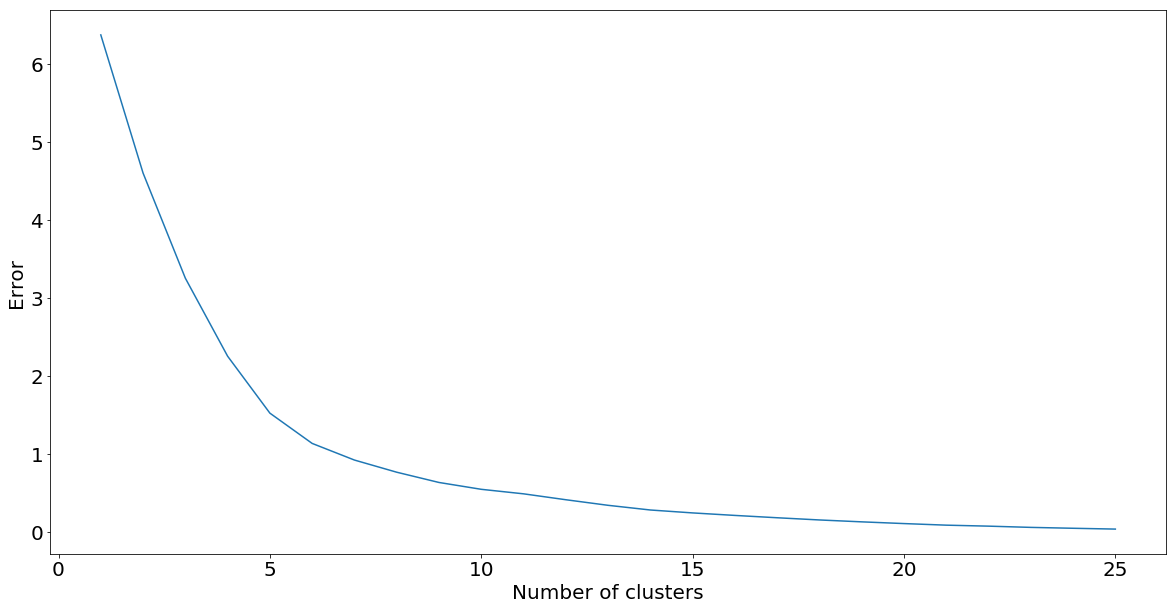

In [31]:
#Creates error for kmeans
evaluate_clusters(pre911, 25)

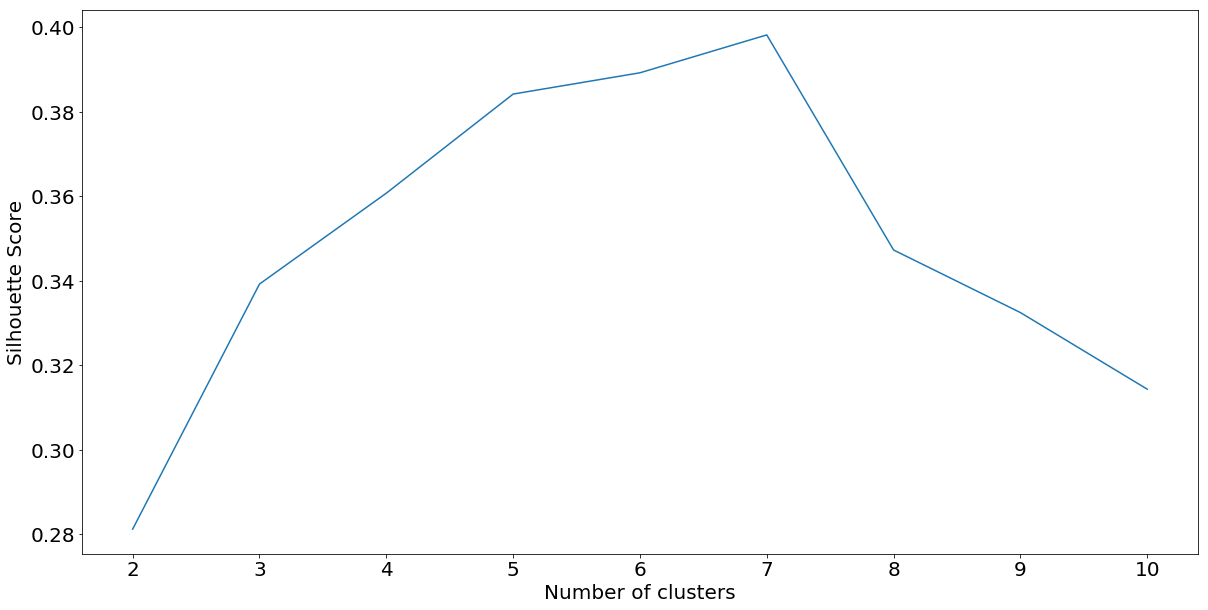

In [33]:
#Creates Silhouette Score for kmeans
sc_evaluate_clusters(pre911,10) 

In [34]:
kmeans_centroids_pre911, kmeans_labels_pre911, kmean_legend_pre911, kmean_count_pre911 = kmean_clustering(pre911,7, FV_pre911, Feature_vector_pre911, 'pre911',weapons_legend)

C:\Users\erici\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


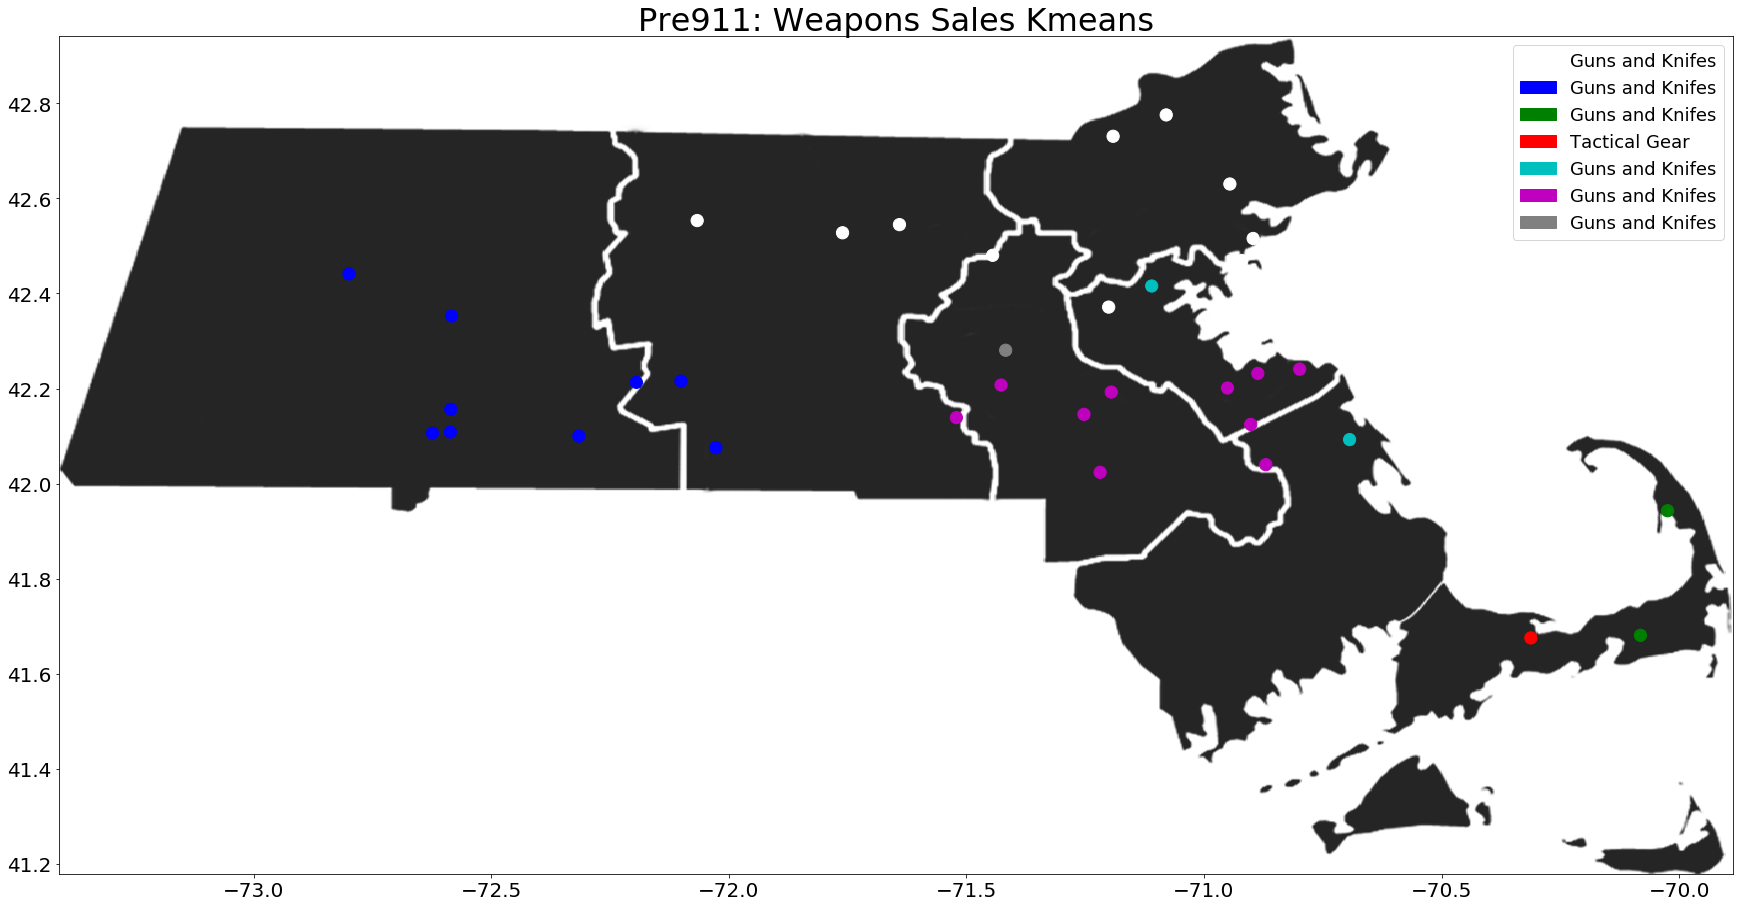

In [35]:
graph_cluster('massachusetts.png', 'Pre911: Weapons Sales Kmeans', 'kmean_label_pre911', 'Pre911_kmeans.png', Feature_vector_master, FV_pre911, kmean_legend_pre911, 0)

# Post 9/11

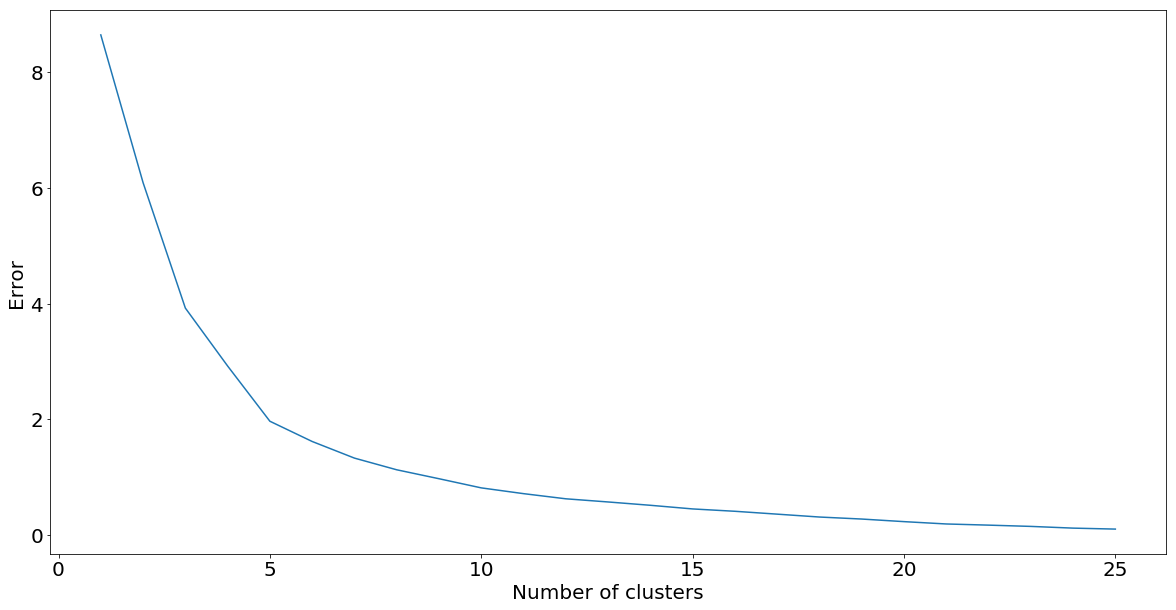

In [36]:
#Creates error for kmeans
evaluate_clusters(post911, 25)

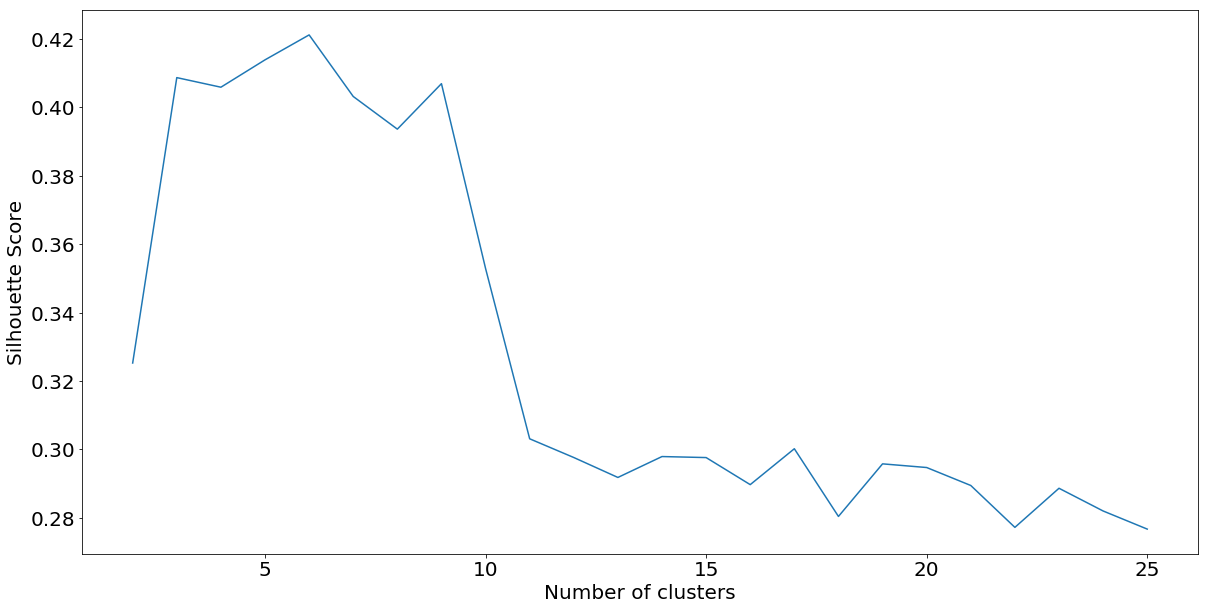

In [37]:
#Creates Silhouette Score for kmeans
sc_evaluate_clusters(post911,25)

In [38]:
kmeans_centroids_post911, kmeans_labels_post911, kmean_legend_post911, kmean_count_post911 = kmean_clustering(post911,6, FV_post911, Feature_vector_post911, 'post911',weapons_legend)

C:\Users\erici\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


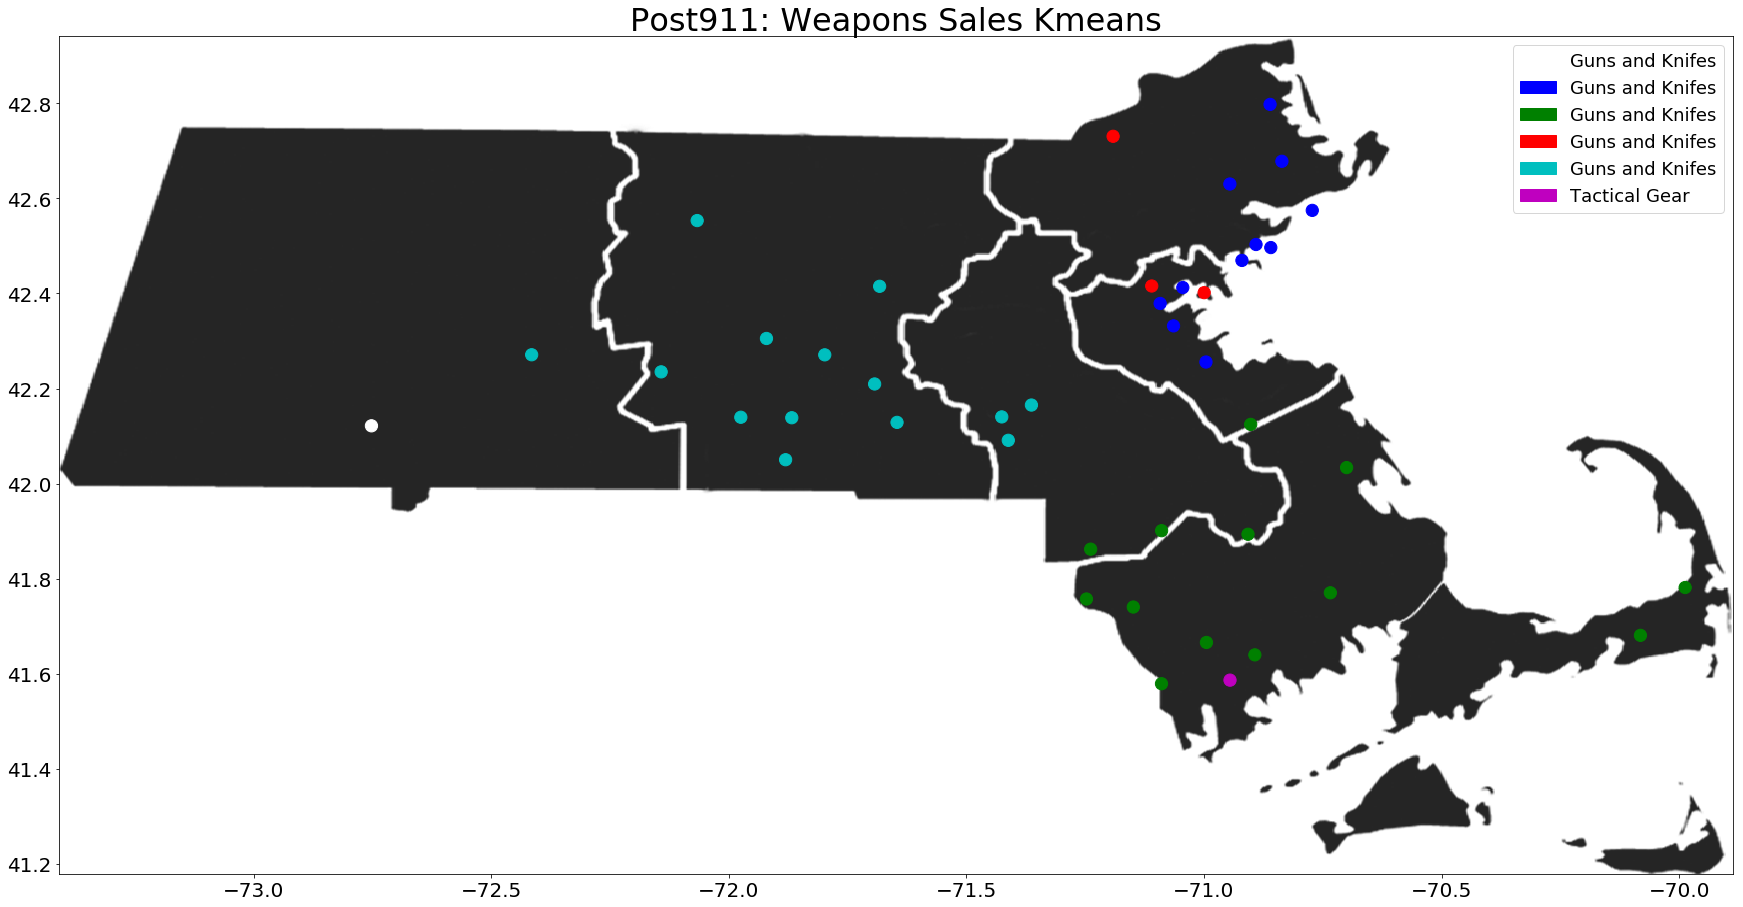

In [39]:
graph_cluster('massachusetts.png', 'Post911: Weapons Sales Kmeans', 'kmean_label_post911', 'Post911_kmeans.png', Feature_vector_master, FV_post911, kmean_legend_post911, 0)

# 2010 and later

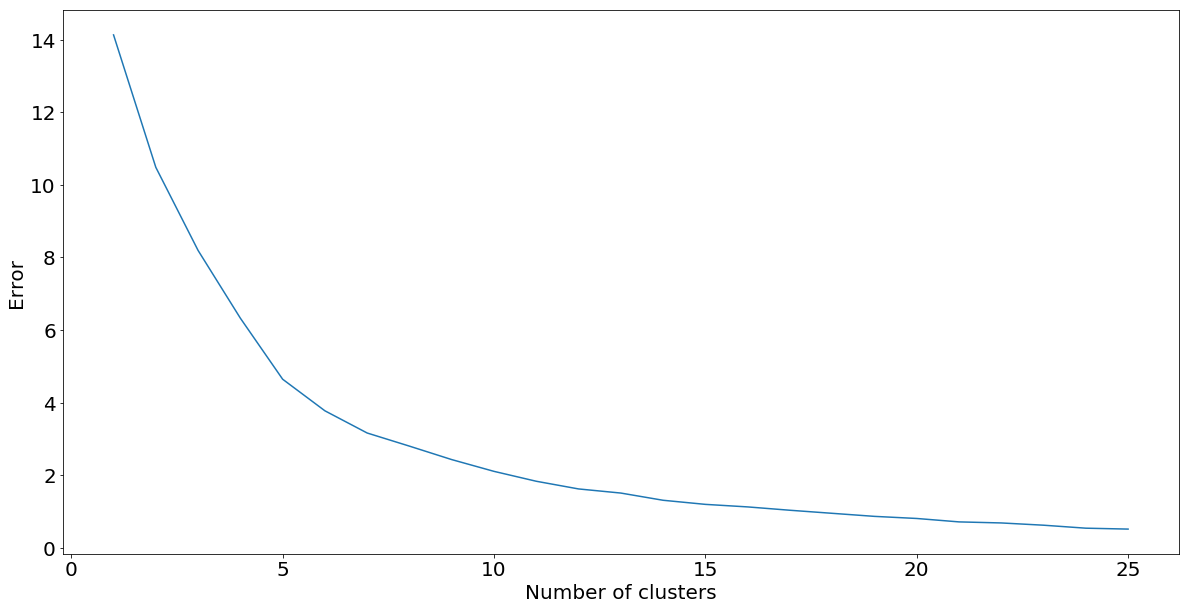

In [42]:
#Creates error for kmeans
evaluate_clusters(plus2010, 25)

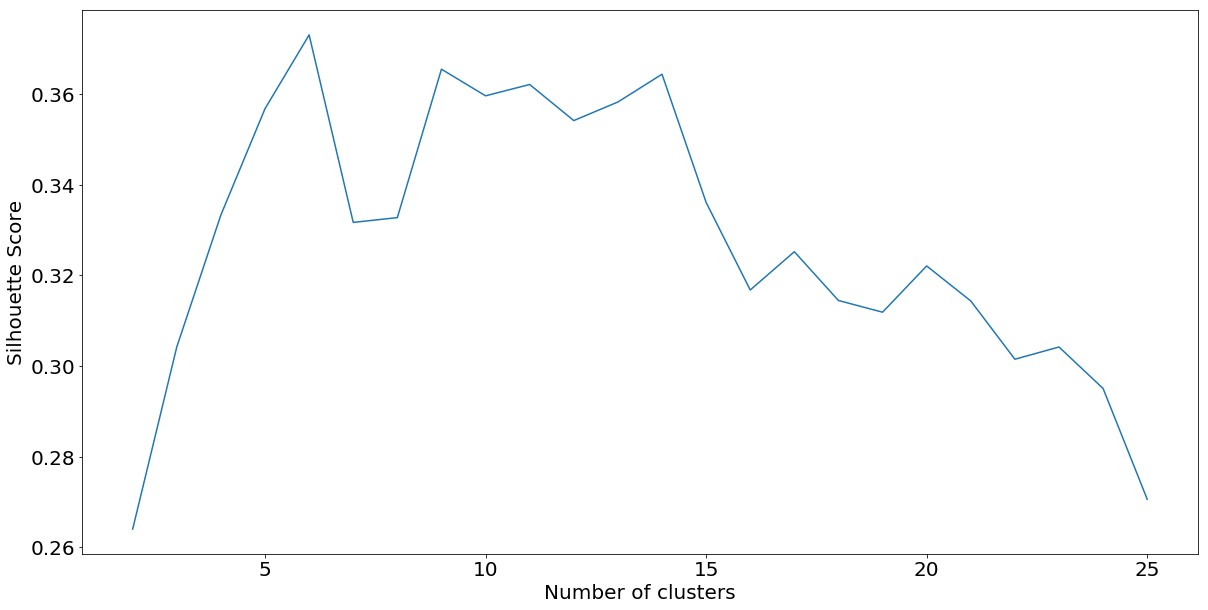

In [43]:
#Creates Silhouette Score for kmeans
sc_evaluate_clusters(plus2010,25) 

In [44]:
kmeans_centroids_plus2010, kmeans_labels_plus2010, kmean_legend_plus2010, kmean_count_plus2010 = kmean_clustering(plus2010,5, FV_2010plus, Feature_vector_plus2010, 'plus2010',weapons_legend)

C:\Users\erici\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


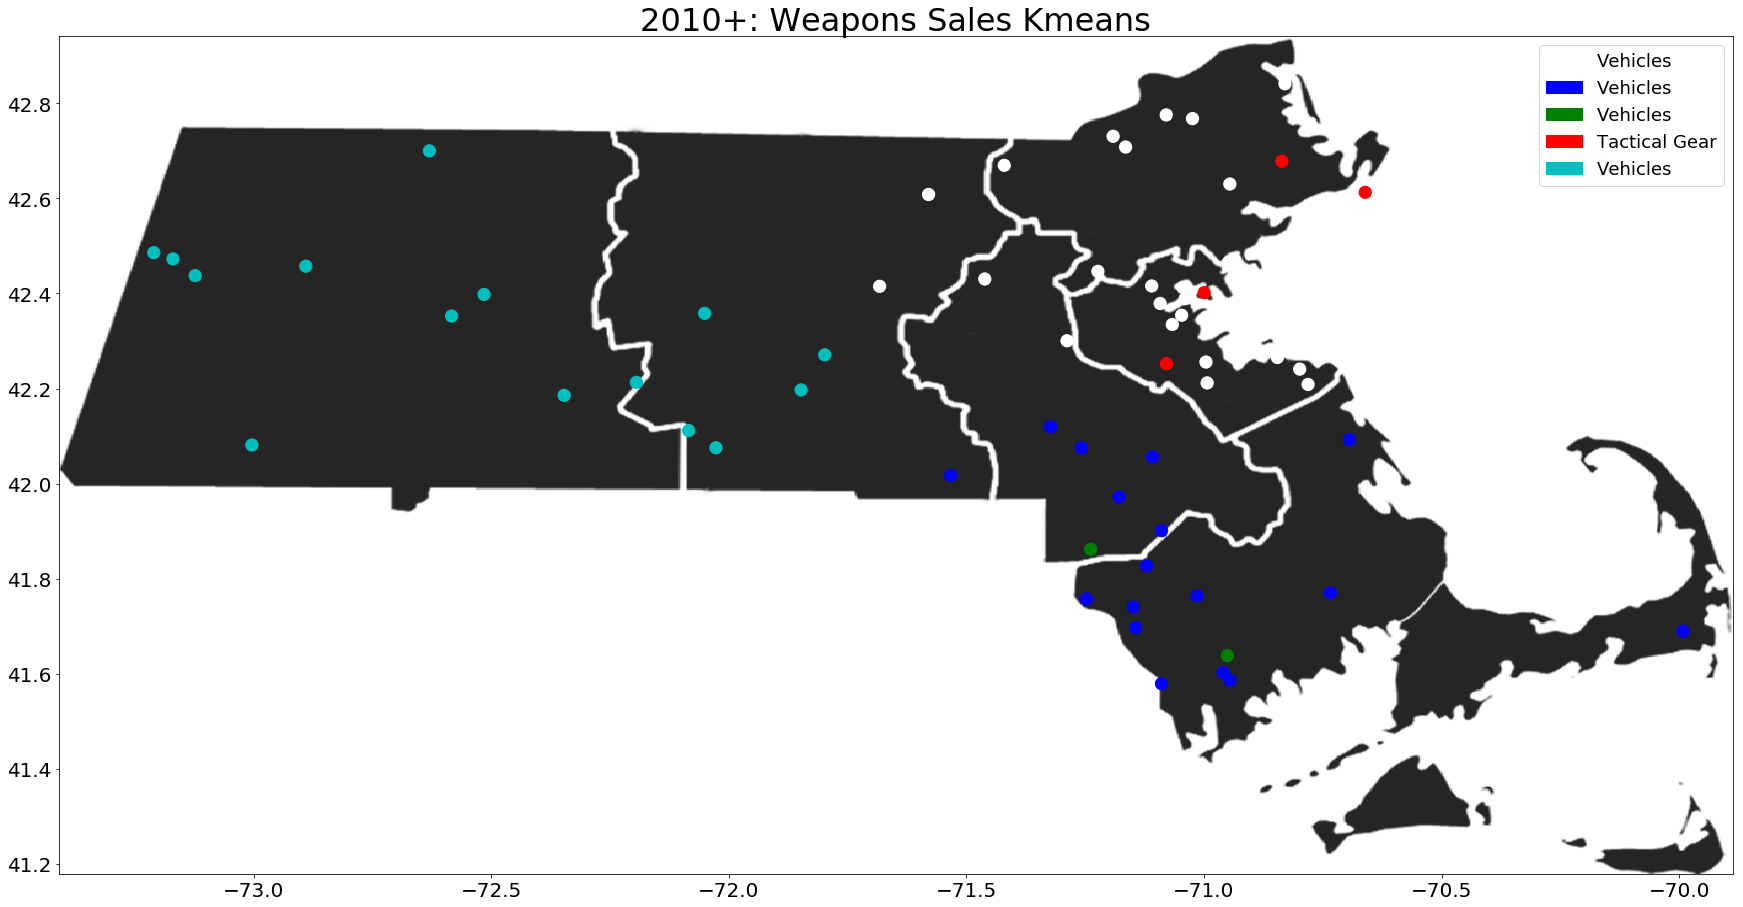

In [45]:
graph_cluster('massachusetts.png', '2010+: Weapons Sales Kmeans', 'kmean_label_plus2010', '2010+_kmeans.png', Feature_vector_master, FV_2010plus, kmean_legend_plus2010, 0)

# GMM Clustering

In [46]:
def gmm_clustering(feature_vector,cluster_num, unscaled_df, scaled_df, col_name,weapons_legend):
    # Creates gmm fit, labeling, and centroids
    gmm = mixture.GaussianMixture(n_components=cluster_num, covariance_type='full')
    gmm.fit(feature_vector)
    gmm_centroids = gmm.means_
    gmm_labels = gmm.predict(feature_vector)
    
    title = 'gmm_label_' + col_name
    unscaled_df[title] = gmm_labels
    scaled_df[title] = gmm_labels
    
    gmm_count = np.zeros(shape=(max(gmm_labels)+1,len(feature_vector[0])-2))
    for i in range(len(gmm_labels)):
        gmm_count[gmm_labels[i]] = gmm_count[gmm_labels[i]] + feature_vector[i][2:]
    gmm_legend = []
    for m in gmm_count:
        max_index = [i for i, j in enumerate(m) if j == max(m)]
        gmm_legend.append(weapons_legend[max_index[0]])
    
    return gmm_centroids, gmm_labels, gmm_legend, gmm_count

# Pre 9/11

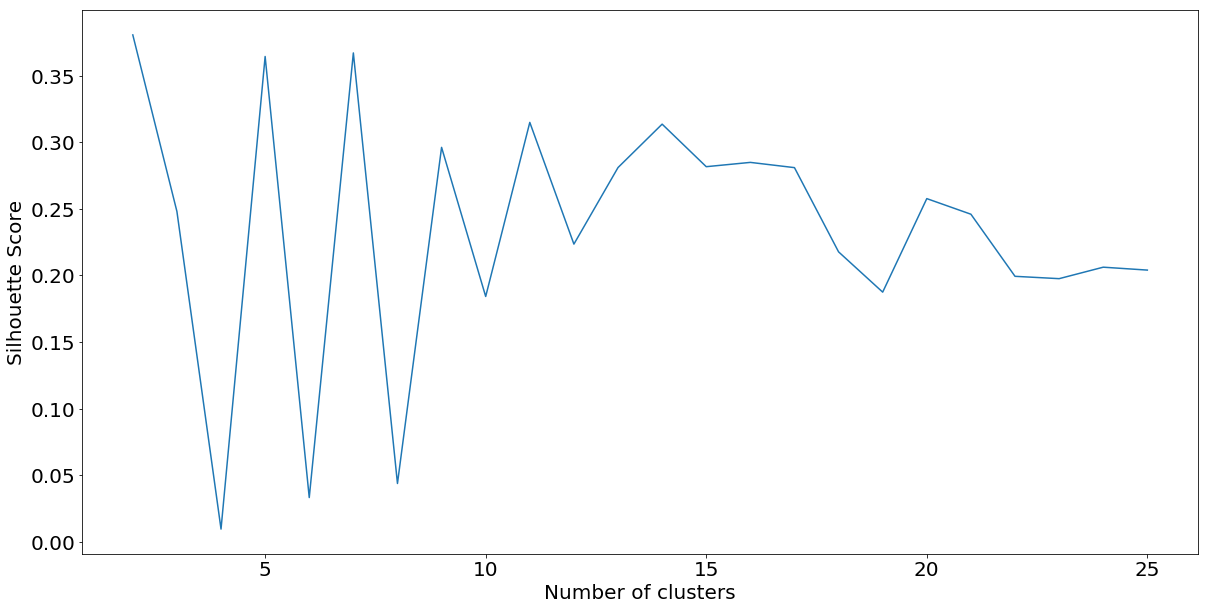

In [47]:
#Creates Silhouette Score for GMM
sc_evaluate_clusters_gmm(pre911,25) 

In [48]:
gmm_centroids_pre911, gmm_labels_pre911, gmm_legend_pre911, gmm_count_pre911 = gmm_clustering(pre911,5, FV_pre911, Feature_vector_pre911, 'pre911',weapons_legend)

C:\Users\erici\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


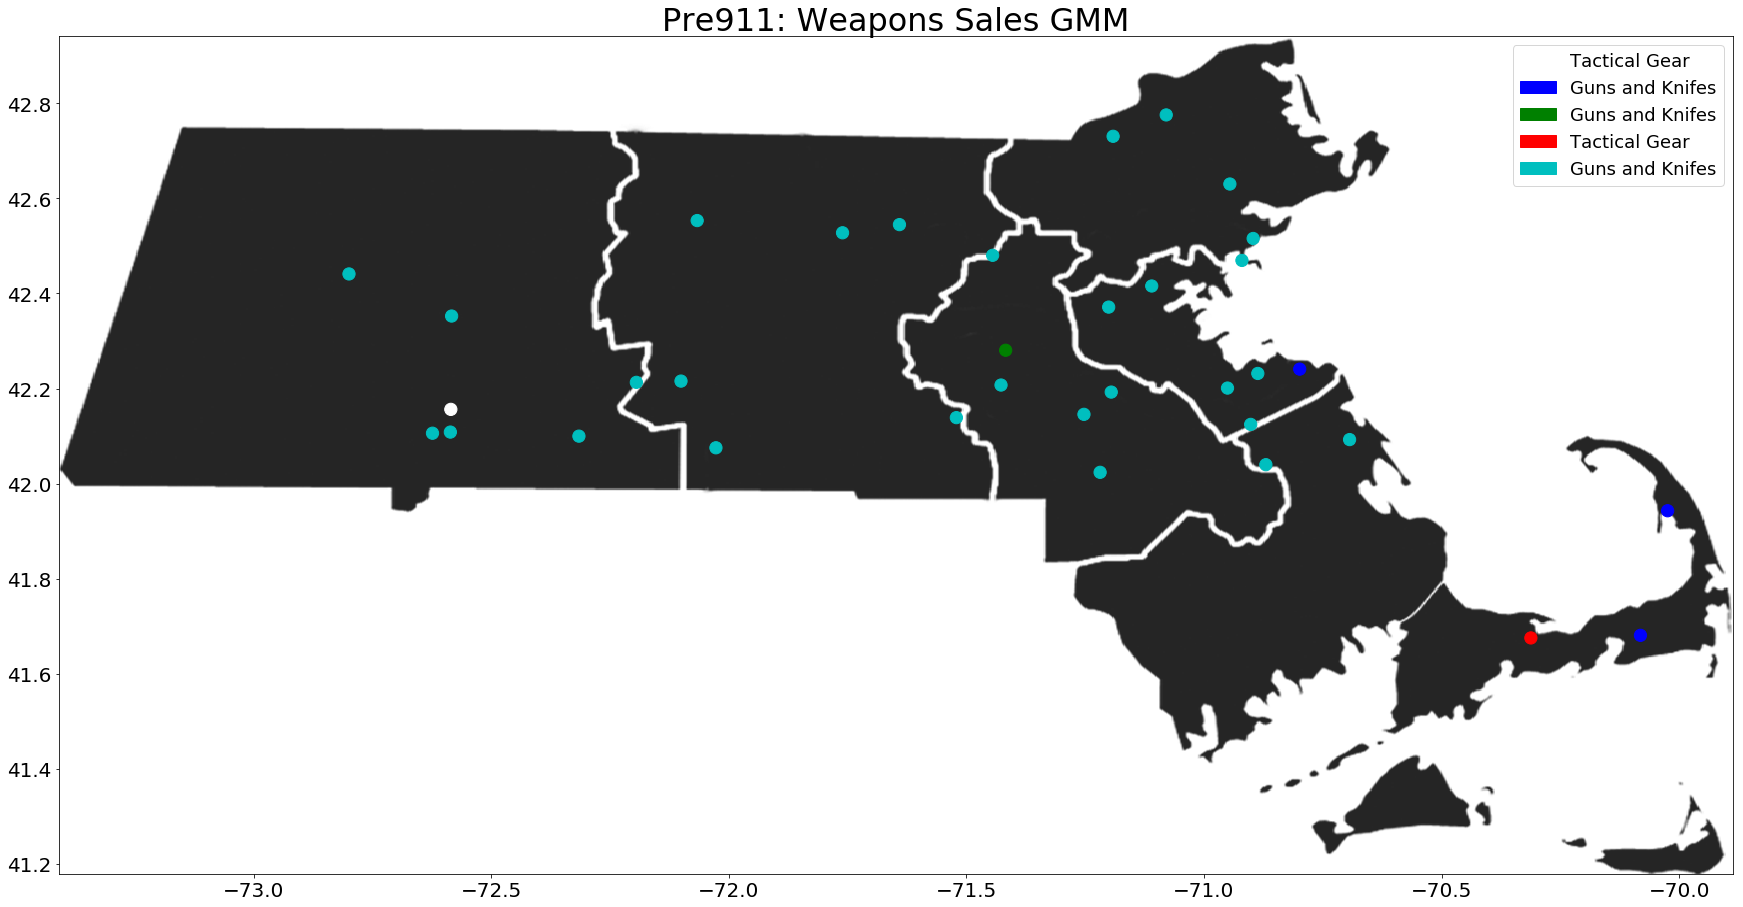

In [49]:
graph_cluster('massachusetts.png', 'Pre911: Weapons Sales GMM', 'gmm_label_pre911', 'Pre911_GMM.png', Feature_vector_master, FV_pre911, gmm_legend_pre911, 0)

# Post 9/11

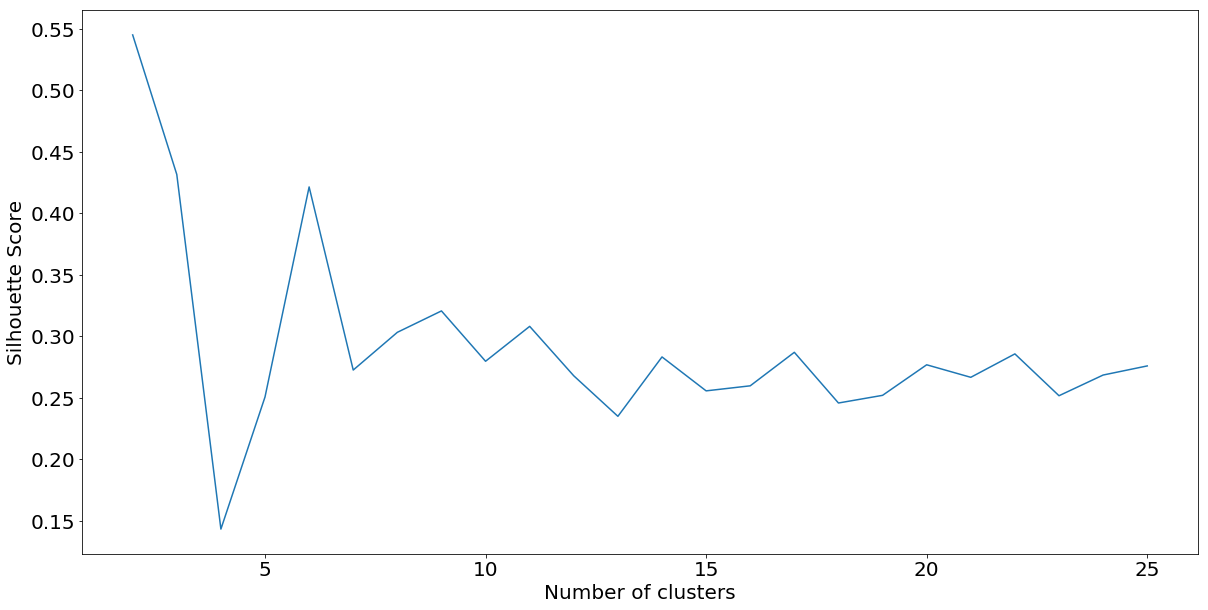

In [50]:
#Creates Silhouette Score for GMM
sc_evaluate_clusters_gmm(post911,25) 

In [51]:
gmm_centroids_post911, gmm_labels_post911, gmm_legend_post911, gmm_count_post911 = gmm_clustering(post911,5, FV_post911, Feature_vector_post911, 'post911',weapons_legend)

C:\Users\erici\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


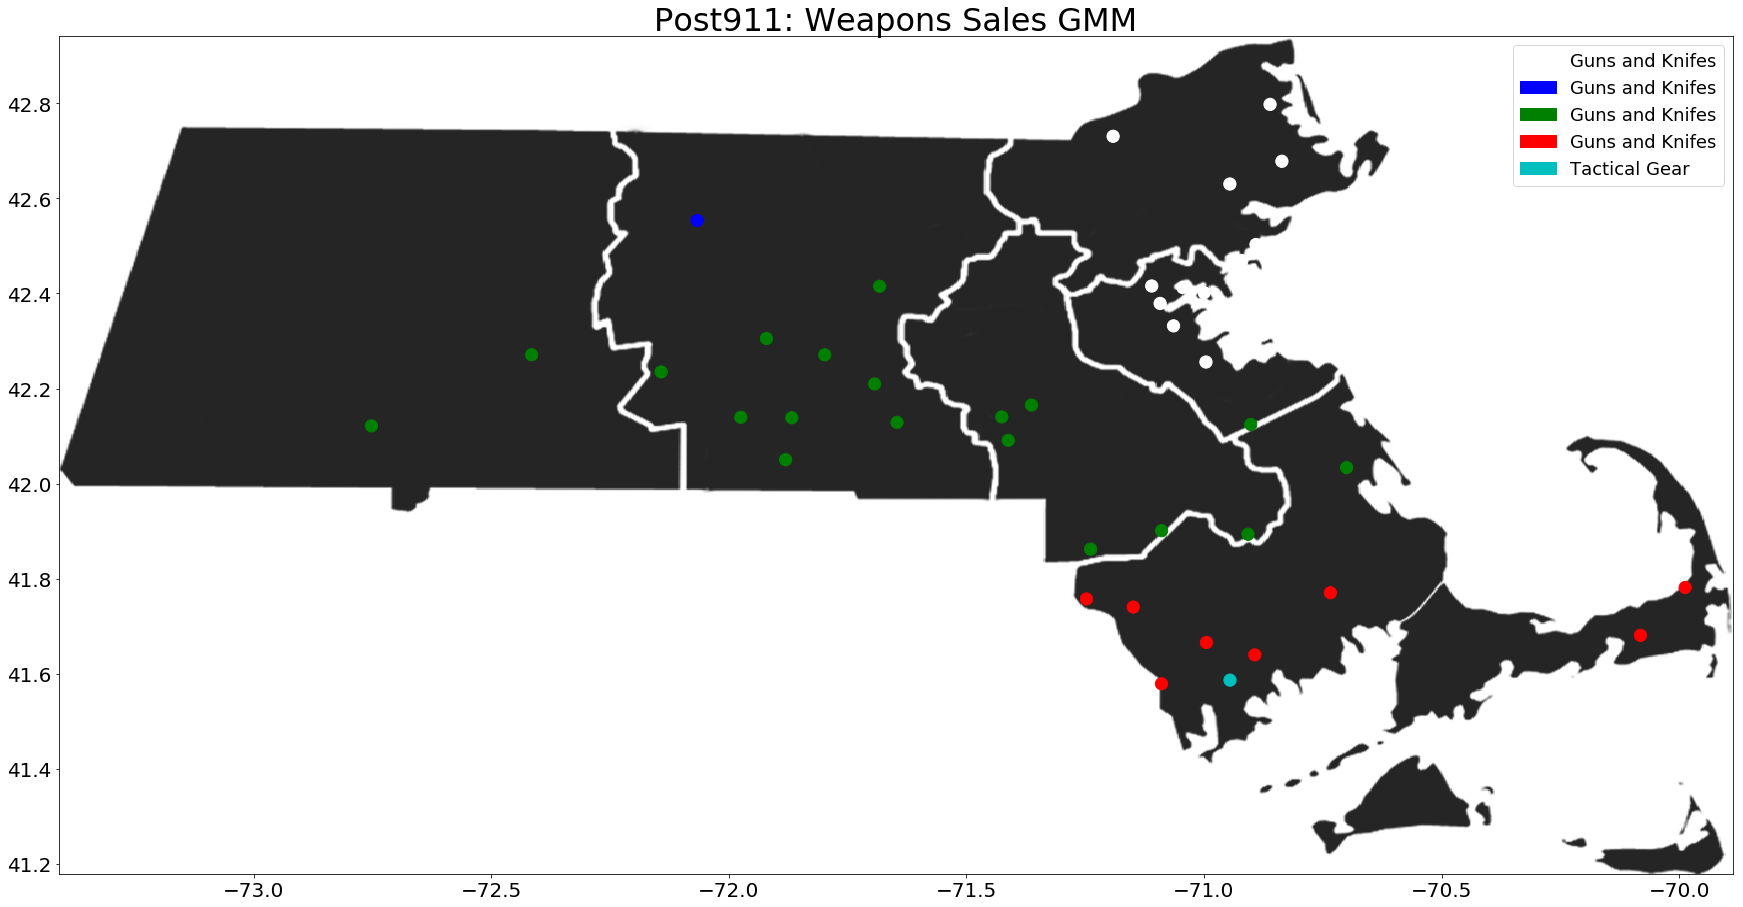

In [53]:
graph_cluster('massachusetts.png', 'Post911: Weapons Sales GMM', 'gmm_label_post911', 'Post911_GMM.png', Feature_vector_master, FV_post911, gmm_legend_post911, 0)

# 2010 and later

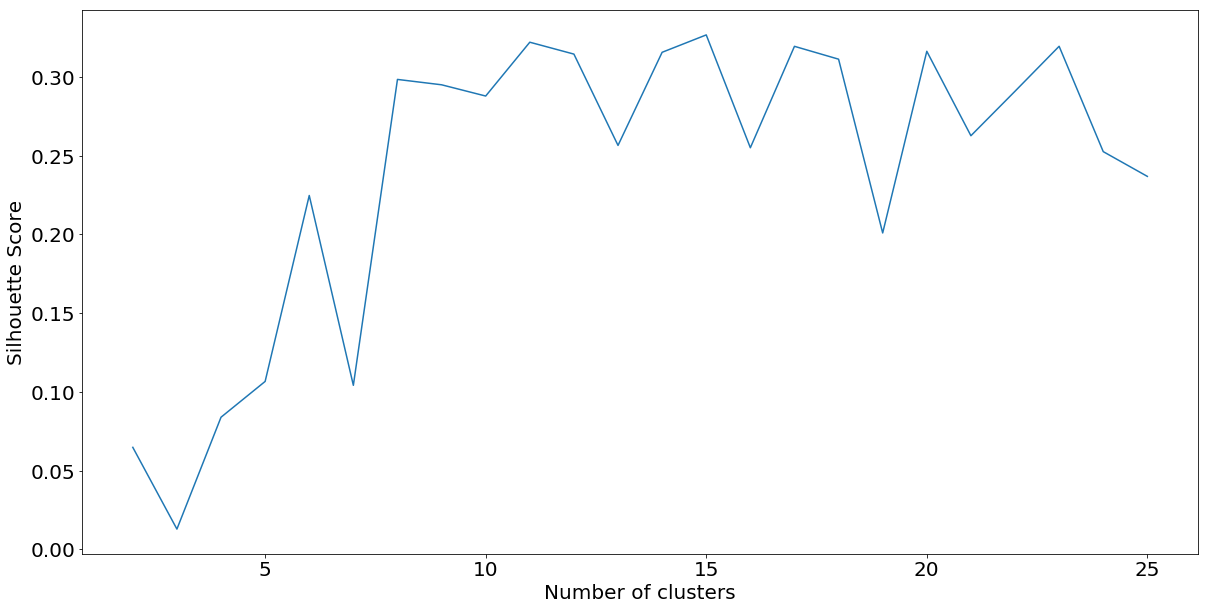

In [54]:
#Creates Silhouette Score for GMM
sc_evaluate_clusters_gmm(plus2010,25) 

In [55]:
gmm_centroids_plus2010, gmm_labels_plus2010, gmm_legend_plus2010, gmm_count_plus2010 = gmm_clustering(plus2010,4, FV_2010plus, Feature_vector_plus2010, 'plus2010',weapons_legend)

C:\Users\erici\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


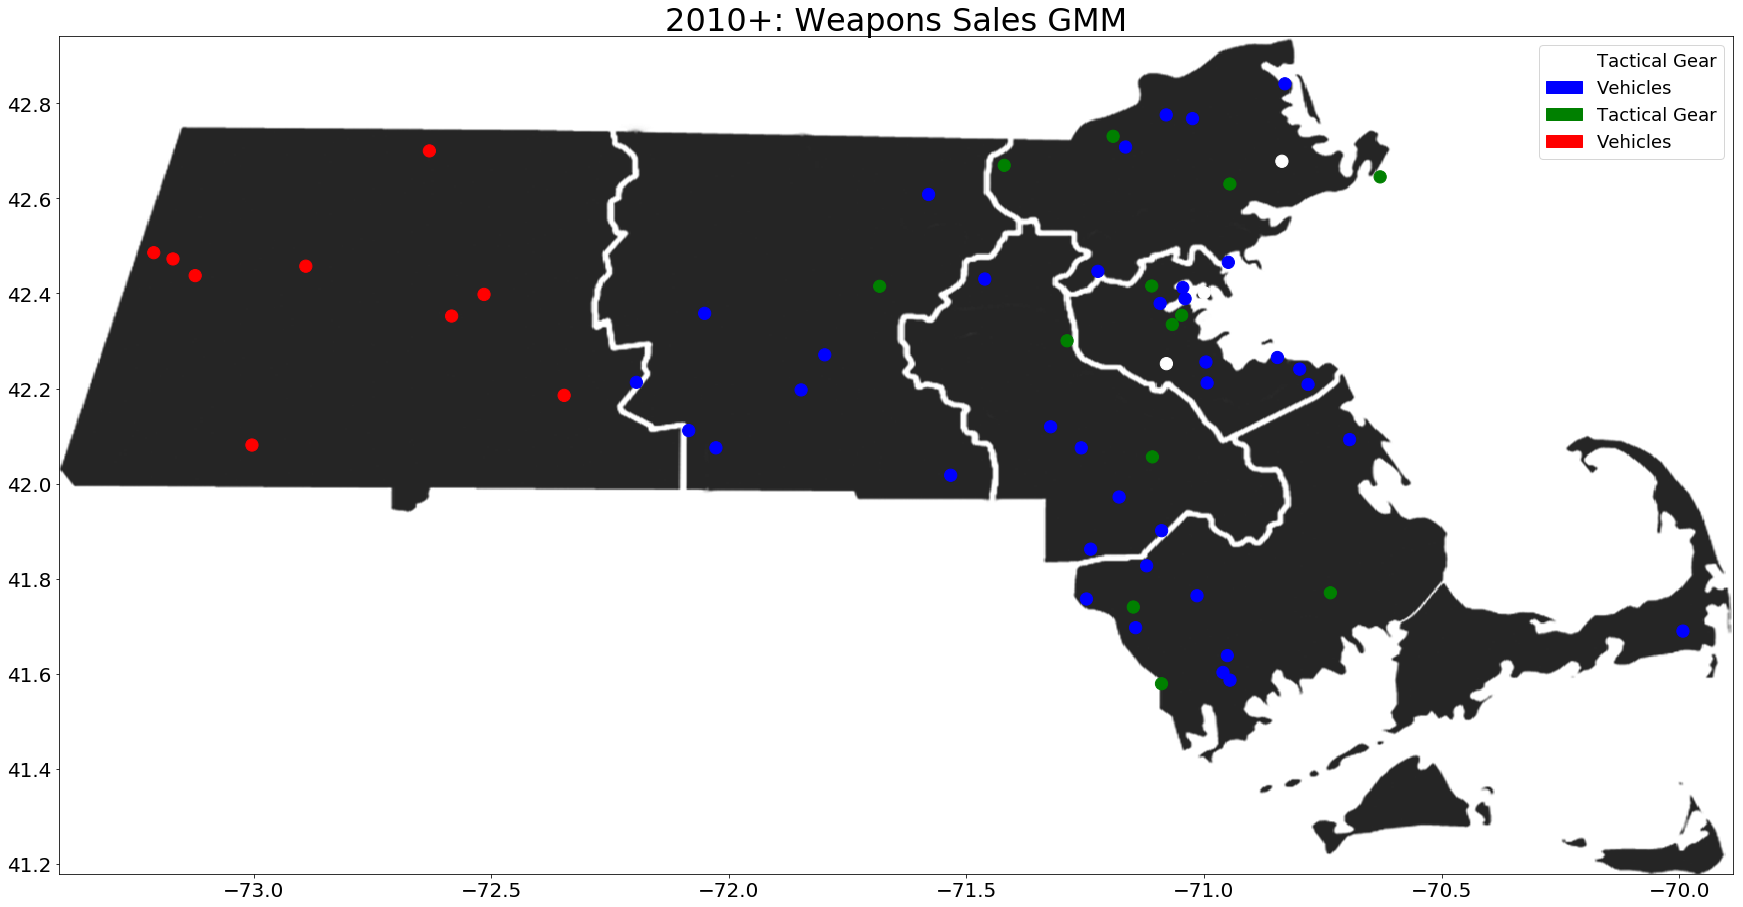

In [56]:
graph_cluster('massachusetts.png', '2010+: Weapons Sales GMM', 'gmm_label_plus2010', 'Plus2010_GMM.png', Feature_vector_master, FV_2010plus, gmm_legend_plus2010, 0)